In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Configuration
DATA_DIR = './clothes_dataset' 
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Setup complete. Using device: {DEVICE}")

Setup complete. Using device: cpu


In [4]:
def load_data(data_dir):
    images = []
    labels = []
    
    if not os.path.exists(data_dir):
        print(f"Error: Directory {data_dir} not found.")
        return np.array([]), np.array([]), {}
    
    # scan for classes
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    class_map = {cls: i for i, cls in enumerate(classes)}
    
    print(f"Found classes: {classes}")
    
    for cls, idx in class_map.items():
        cls_path = os.path.join(data_dir, cls)
        # limit to first 500 images per class if dataset is huge to save time
        for img_name in os.listdir(cls_path): 
            try:
                img_path = os.path.join(cls_path, img_name)
                with Image.open(img_path) as img:
                    img = img.resize(IMG_SIZE).convert('RGB')
                    images.append(np.array(img))
                    labels.append(idx)
            except Exception as e:
                pass
                
    return np.array(images), np.array(labels), class_map

# Load Data
X_raw, y, class_map = load_data(DATA_DIR)
print(f"Loaded {len(X_raw)} images. Shape: {X_raw.shape}")

# Flatten: (N, 64, 64, 3) -> (N, 12288)
X_flat = X_raw.reshape(X_raw.shape[0], -1)

# Split 80:20 Stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize (Standard Scaling) - CRITICAL for LogReg and MLP
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

print("Data preprocessing complete.")

Found classes: ['Blazer', 'Celana_Panjang', 'Celana_Pendek', 'Gaun', 'Hoodie', 'Jaket', 'Jaket_Denim', 'Jaket_Olahraga', 'Jeans', 'Kaos', 'Kemeja', 'Mantel', 'Polo', 'Rok', 'Sweter']
Loaded 7500 images. Shape: (7500, 64, 64, 3)
Data preprocessing complete.


In [12]:
print("--- Task 1: Logistic Regression ---")

# Initialize and Train
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1)
log_reg.fit(X_train_norm, y_train)

# Predict and Evaluate
y_pred_lr = log_reg.predict(X_test_norm)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')

print(f"Logistic Regression Macro F1 Score: {f1_lr:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr, target_names=class_map.keys()))

--- Task 1: Logistic Regression ---


D:\jupyter_ntb\jupyter_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression Macro F1 Score: 0.3014

Classification Report:

                precision    recall  f1-score   support

        Blazer       0.12      0.13      0.12       100
Celana_Panjang       0.27      0.30      0.28       100
 Celana_Pendek       0.36      0.45      0.40       100
          Gaun       0.25      0.20      0.22       100
        Hoodie       0.31      0.26      0.28       100
         Jaket       0.39      0.38      0.39       100
   Jaket_Denim       0.32      0.29      0.30       100
Jaket_Olahraga       0.26      0.24      0.25       100
         Jeans       0.52      0.54      0.53       100
          Kaos       0.42      0.40      0.41       100
        Kemeja       0.27      0.26      0.27       100
        Mantel       0.30      0.23      0.26       100
          Polo       0.23      0.31      0.27       100
           Rok       0.21      0.20      0.21       100
        Sweter       0.31      0.35      0.33       100

      accuracy                    

In [14]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_norm).to(DEVICE)
y_train_tensor = torch.LongTensor(y_train).to(DEVICE)
X_test_tensor = torch.FloatTensor(X_test_norm).to(DEVICE)
y_test_tensor = torch.LongTensor(y_test).to(DEVICE)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define Dynamic MLP Model
class DynamicMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, activation_fn):
        super(DynamicMLP, self).__init__()
        layers = []
        in_dim = input_dim
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, 128)) 
            layers.append(activation_fn())
            in_dim = 128
            
        layers.append(nn.Linear(in_dim, output_dim))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Training Function
def train_and_evaluate(hidden_layers, activation_fn):
    model = DynamicMLP(
        input_dim=X_train_norm.shape[1], 
        output_dim=len(class_map), 
        hidden_layers=hidden_layers, 
        activation_fn=activation_fn
    ).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        f1 = f1_score(y_test_tensor.cpu(), predicted.cpu(), average='macro')
    return f1

print("MLP Class and Training Loop defined.")

MLP Class and Training Loop defined.


--- Task 2: MLP Experiments ---
Running Layer Experiments...
Layers: 1, F1: 0.3794
Layers: 2, F1: 0.3817
Layers: 3, F1: 0.3987

Running Activation Experiments...
Activation: ReLU, F1: 0.3897
Activation: Sigmoid, F1: 0.3189
Activation: Tanh, F1: 0.2867


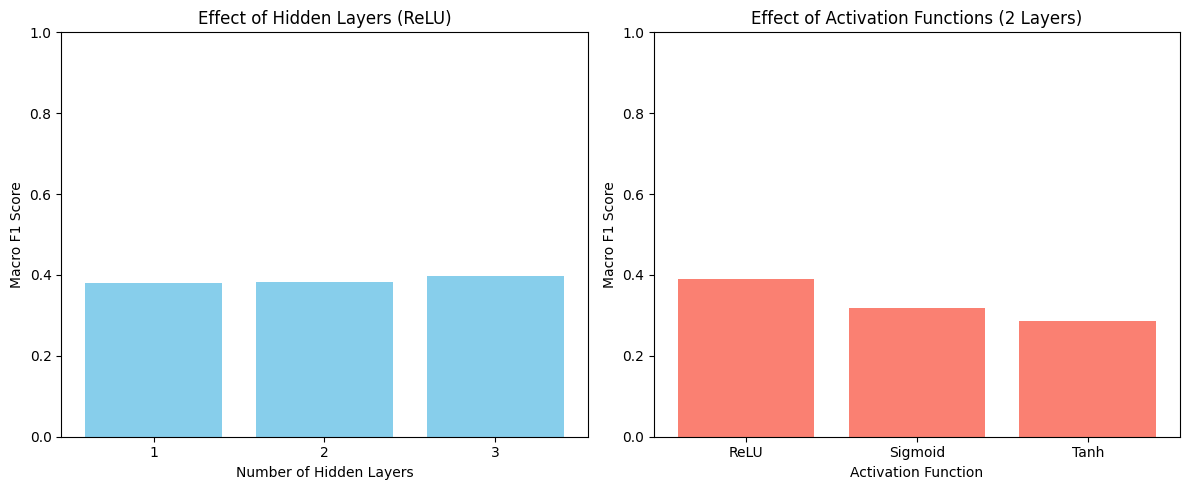

Plot saved as mlp_comparison.png


In [15]:
print("--- Task 2: MLP Experiments ---")


# Experiment A: Varying Hidden Layers (using ReLU)
layer_counts = [1, 2, 3]
layer_results = []
print("Running Layer Experiments...")
for count in layer_counts:
    score = train_and_evaluate(count, nn.ReLU)
    layer_results.append(score)
    print(f"Layers: {count}, F1: {score:.4f}")

# Experiment B: Varying Activations (using 2 Layers)
activations = {"ReLU": nn.ReLU, "Sigmoid": nn.Sigmoid, "Tanh": nn.Tanh}
act_results = []
print("\nRunning Activation Experiments...")
for name, fn in activations.items():
    score = train_and_evaluate(2, fn)
    act_results.append(score)
    print(f"Activation: {name}, F1: {score:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Layers
plt.subplot(1, 2, 1)
plt.bar([str(l) for l in layer_counts], layer_results, color='skyblue')
plt.title("Effect of Hidden Layers (ReLU)")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Macro F1 Score")
plt.ylim(0, 1.0)

# Plot 2: Activations
plt.subplot(1, 2, 2)
plt.bar(activations.keys(), act_results, color='salmon')
plt.title("Effect of Activation Functions (2 Layers)")
plt.xlabel("Activation Function")
plt.ylabel("Macro F1 Score")
plt.ylim(0, 1.0)

plt.tight_layout()
plt.savefig("mlp_comparison.png")
plt.show()

print("Plot saved as mlp_comparison.png")